In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

## Loading the stroke dataset into a pandas' dataframe 

In [4]:
df = pd.read_csv("Downloads/newData.csv")

## Separating out the features and the target variable

In [42]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1:]

## flattening the target variable
y = np.ravel(y)

### Creating the train test splits for training and testing 

In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Using Random Forest classifier with 100 weak learners (decision trees) and the maxDepth is set to 5

#### - Random Forest classifier is used to avoid the overfitting problem

In [78]:
model = RandomForestClassifier(n_estimators=100, max_depth=5)

### Using cross validation with the no. of splits set to 5, to evaluate the model's performance on 5 different validation sets.

In [81]:
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print(scores)

[0.78303342 0.80462725 0.79320988 0.80092593 0.78858025]


### Training the model and making predictions on the test set

In [83]:
model.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=5)

In [84]:
predictions = model.predict(xtest)

In [85]:
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

           0       0.87      0.73      0.79      1466
           1       0.77      0.89      0.82      1451

    accuracy                           0.81      2917
   macro avg       0.82      0.81      0.81      2917
weighted avg       0.82      0.81      0.81      2917



In [86]:
y_prob = model.predict_proba(xtest)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(ytest, y_prob)


In [94]:
# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)


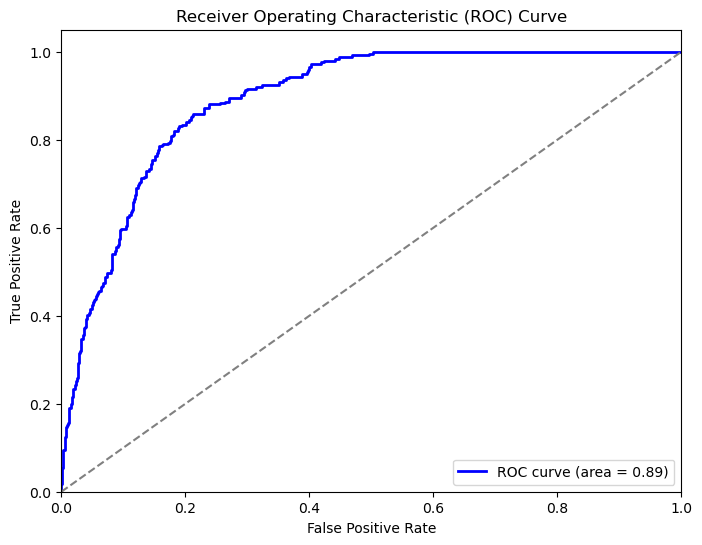

In [96]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

### Using the Standard Scaler to normalize the dataset, with mean being set to 0 and standardard deviation to 1

In [26]:
scaler = StandardScaler()
xtrain.iloc[:, :3] = scaler.fit_transform(xtrain.iloc[:, :3])
xtest.iloc[:, :3] = scaler.transform(xtest.iloc[:, :3])

### Creating the architecture of a NN

In [100]:
model = Sequential()


model.add(InputLayer(shape=(xtrain.shape[1],)))
model.add(Dense(64, activation='relu')) ## Relu act function is used to avoid the vanishing graidient problem,
                                        ## and also because of the fact that relu Act function is zero centered.
model.add(BatchNormalization()) ## for smooth convergence, as it helps the NN to keep the weights' distribution consistent
                                ## across different layers.
model.add(Dropout(0.2))  


model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid')) ## Sigmoid Act function for the last layer as it is a binary problem.


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) ## Binary Crossentropy loss for a binary problem.


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(xtrain, ytrain, epochs=100, batch_size=32,
                    validation_data=(xtest, ytest),
                    callbacks=[early_stopping])


loss, accuracy = model.evaluate(xtest, ytest)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


y_pred = model.predict(xtest)

Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6456 - loss: 0.6642 - val_accuracy: 0.7789 - val_loss: 0.4890
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.7630 - loss: 0.5055 - val_accuracy: 0.8073 - val_loss: 0.4363
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.7641 - loss: 0.4918 - val_accuracy: 0.8145 - val_loss: 0.4148
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7812 - loss: 0.4799 - val_accuracy: 0.8265 - val_loss: 0.4068
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.7832 - loss: 0.4587 - val_accuracy: 0.8320 - val_loss: 0.3947
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.7752 - loss: 0.4594 - val_accuracy: 0.8210 - val_loss: 0.3851
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.7933 - loss: 0.4467 - val_accuracy: 0.8330 - val_loss: 0.3804
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.8022 - loss: 0.4

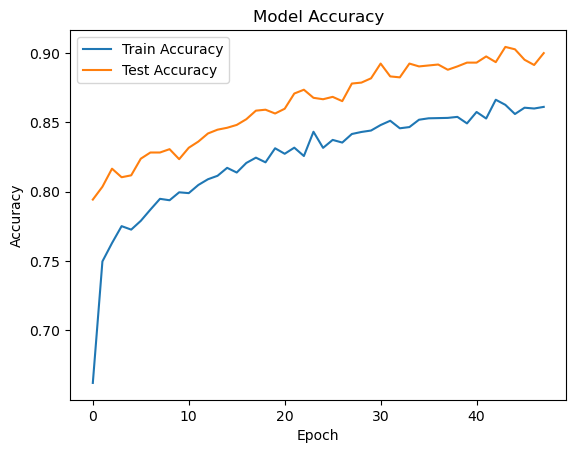

In [30]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

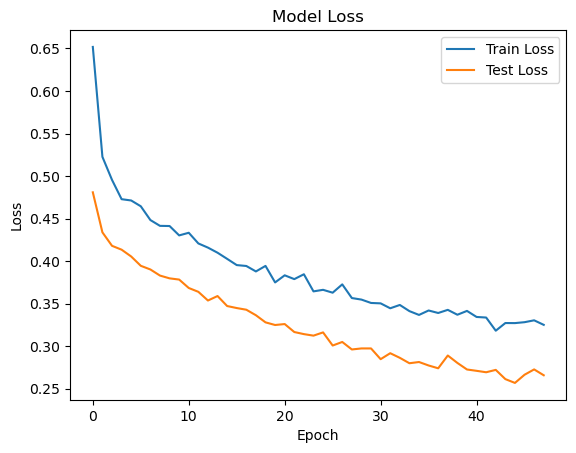

In [32]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [34]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(ytest, y_pred)


In [36]:
# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)


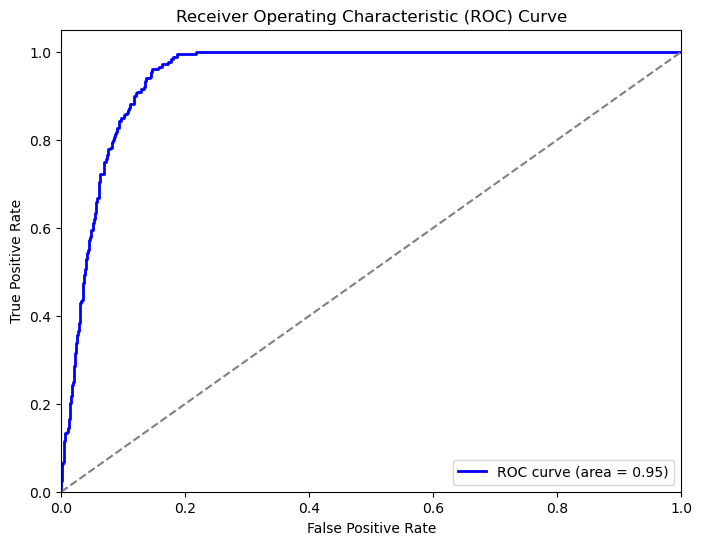

In [38]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')